In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from shutil import copyfile

In [2]:
BATCH_SIZE=32

TRAINING_DIR = "dataset/training"
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    color_mode='rgb',
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='sparse',
                                                    target_size=(224, 224))

VALIDATION_DIR = "dataset/testing"
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              color_mode='rgb',
                                                              batch_size=BATCH_SIZE,
                                                              class_mode='sparse',
                                                              target_size=(224, 224))

Found 61979 images belonging to 27 classes.
Found 15511 images belonging to 27 classes.


In [3]:
base_model = tf.keras.applications.ResNet50V2(weights="imagenet",input_shape=(224,224,3),include_top = False)
#base_model.summary()

In [4]:
# Base model layers will be frozen. Only new layers added on top will be trained
for layer in base_model.layers:
    layer.trainable = False
    
last_output = base_model.layers[-1].output

In [5]:
# Last ouput is flattened to get 1D Array for dense network
# Some layers are added to suit more to our problem

core_model = tf.keras.layers.Flatten()(last_output)
core_model = tf.keras.layers.BatchNormalization()(core_model) #To reduce vanishing/exploding gradients problems

core_model = tf.keras.layers.Dense(128,kernel_initializer="he_normal", use_bias=False)(core_model)
core_model = tf.keras.layers.BatchNormalization()(core_model) 
core_model = tf.keras.layers.Activation('relu')(core_model)
core_model = tf.keras.layers.Dropout(0.4)(core_model) # To avoid overfitting 

core_model = tf.keras.layers.Dense(64,kernel_initializer="he_normal", use_bias=False)(core_model)
core_model = tf.keras.layers.BatchNormalization()(core_model) 
core_model = tf.keras.layers.Activation('relu')(core_model)
core_model = tf.keras.layers.Dropout(0.4)(core_model)

# Final layer is applying softmax function to get multiclass output
output = tf.keras.layers.Dense(27, activation=tf.nn.softmax)(core_model)

my_model = tf.keras.Model(inputs=base_model.input, outputs=output)

In [6]:
optimizer = tf.keras.optimizers.Adam()

my_model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [7]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=2, mode='min', restore_best_weights=True, monitor='val_loss')

In [8]:
history = my_model.fit(train_generator,
                              epochs=50,
                              verbose=1,
                              validation_data=validation_generator,
                              callbacks=[early_stopping])

Epoch 1/50
1937/1937 [==============================] - 553s 285ms/step - loss: 1.8824 - accuracy: 0.4271 - val_loss: 0.7396 - val_accuracy: 0.7749
Epoch 2/50
1937/1937 [==============================] - 510s 263ms/step - loss: 1.3525 - accuracy: 0.5759 - val_loss: 0.5748 - val_accuracy: 0.8196
Epoch 3/50
1937/1937 [==============================] - 509s 263ms/step - loss: 1.1957 - accuracy: 0.6246 - val_loss: 0.4764 - val_accuracy: 0.8498
Epoch 4/50
1937/1937 [==============================] - 508s 262ms/step - loss: 1.1132 - accuracy: 0.6523 - val_loss: 0.4179 - val_accuracy: 0.8676
Epoch 5/50
1937/1937 [==============================] - 510s 263ms/step - loss: 1.0435 - accuracy: 0.6737 - val_loss: 0.3806 - val_accuracy: 0.8800
Epoch 6/50
1937/1937 [==============================] - 508s 262ms/step - loss: 0.9876 - accuracy: 0.6937 - val_loss: 0.3363 - val_accuracy: 0.8957
Epoch 7/50
1937/1937 [==============================] - 510s 263ms/step - loss: 0.9625 - accuracy: 0.7024 - val_

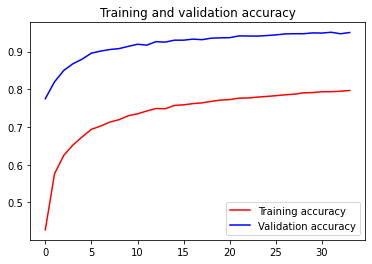

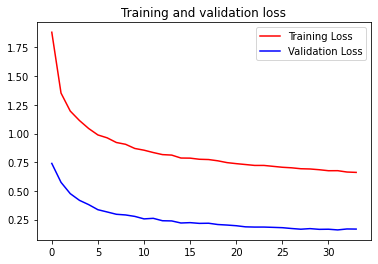

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [10]:
my_model.save('asl_model.h5')

In [12]:
import cv2

In [30]:
face_img = cv2.imread('IMG_20201213_155624.jpg')
face_img = cv2.resize(face_img, (224,224))
face_img = np.expand_dims(face_img,0)
pred = my_model.predict(face_img)
pred_class_index = np.argmax(pred)
for class_name in enumerate(train_generator.class_indices):
    if pred_class_index == class_name[0]:
        print(class_name[1])

W
